## README


**All list of homonyms and processed data is present in the following directory in Google Drive that is required to run the notebook:**
https://drive.google.com/drive/folders/10BSrE8nLbX46dxQIHzNv5wo_Fv-LqZn0?usp=sharing


**It would be advisable to save a copy of this folder to your own drive and then start from checkpoint 5 in this notebook to replicate the results.**

Different checkpoints are provided to help ease the process of replicating results.
**One can search for Checkpoint 5 in this notebook and start executing the cells.**


Whenever possible, comments are provided to enhance the understandability of the code. Make sure you have all the python packages installed to run the checkpoints.

Set up BERT model -> using an API given in the following link:
https://github.com/imgarylai/bert-embedding



In [0]:
pip install --upgrade numpy==1.14.6

     |████████████████████████████████| 13.8MB 308kB/s 
ERROR: xarray 0.15.1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: umap-learn 0.4.0 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: spacy 2.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: plotnine 0.6.0 has requirement numpy>=1.16.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: numba 0.48.0 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: imgaug 0.2.9 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
ERROR: fastai 1.0.60 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [0]:
!pip install bert-embedding

     |████████████████████████████████| 29.6MB 134kB/s 
     |████████████████████████████████| 215kB 47.3MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.6.0-cp36-none-any.whl size=259916 sha256=dbf132a0d1edad3b2458b182cd9207fa6e8082718a982e89444bcb27717f3f03
  Stored in directory: /root/.cache/pip/wheels/ff/48/ac/a77c79aa416ba6dd7bf487f2280b0471034f66141617965914
Successfully built gluonnlp
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [0]:
from bert_embedding.bert import BertEmbedding

In [0]:
bert_model = BertEmbedding()

Vocab file is not found. Downloading.


Importing the homonym list and SemCor data from Drive. Can then extract sentences that contain homonyms and get embddings for these sentences from BERT.



Use the cleaned up version of SemCor provided by Bradley.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd

In [0]:
homonym_list = pd.read_csv('/content/drive/My Drive/CMPUT600_data/hk20-homonym-resource_homonyms_v01.tsv', delimiter='\t', header=None, names=['word', 'number', 'pos', 'meaning'])

In [0]:
semcor = pd.read_csv('/content/drive/My Drive/CMPUT600_data/semcor.data.xml.ins', delimiter='\t', header=None, names=['sent_id', 'sent', 'word_num', 'un_id', 'lemma', 'pos_tag'])

Now I read in sense-key data and attach to SemCor

In [0]:
semcor_key = pd.read_csv('/content/drive/My Drive/CMPUT600_data/semcor.gold.key.txt', sep=' ', names=['un_id', 'sense_key'], header=None)

In [0]:
semcor_key.head()

,un_id,sense_key
0,d000.s000.t000,long%3:00:02::
1,d000.s000.t001,be%2:42:03::
2,d000.s000.t002,review%2:31:00::
3,d000.s000.t003,objective%1:09:00::
4,d000.s000.t004,benefit%1:21:00::


In [0]:
semcor_with_sensekey = pd.merge(semcor, semcor_key, how='inner', on='un_id')

In [0]:
semcor_vals = semcor_with_sensekey.copy()

In [0]:
semcor_with_sensekey['un_id'] = 'semcor.' + semcor_with_sensekey['un_id'].astype(str)

In [0]:
semcor_with_sensekey.head()

,sent_id,sent,word_num,un_id,lemma,pos_tag,sense_key
0,d000.s000,how long has it been since you reviewed the ob...,1,semcor.d000.s000.t000,long,ADJ,long%3:00:02::
1,d000.s000,how long has it been since you reviewed the ob...,4,semcor.d000.s000.t001,be,VERB,be%2:42:03::
2,d000.s000,how long has it been since you reviewed the ob...,7,semcor.d000.s000.t002,review,VERB,review%2:31:00::
3,d000.s000,how long has it been since you reviewed the ob...,9,semcor.d000.s000.t003,objective,NOUN,objective%1:09:00::
4,d000.s000,how long has it been since you reviewed the ob...,12,semcor.d000.s000.t004,benefit,NOUN,benefit%1:21:00::


In [0]:
semcor_with_sensekey.to_csv('/content/drive/My Drive/CMPUT600_data/semcor_with_sensekey.csv', index=False)

Inner join on 'un_id' from SemCor and gold.key saved as 'semcor_with_sensekeys.csv' in Drive.

From here I will need to remove homonymous words from the list that do not appear in the 'lemma' of Semcor and do the other way around too.

In [0]:
semcor_with_sensekey = pd.read_csv('/content/drive/My Drive/CMPUT600_data/semcor_with_sensekey.csv')

In [0]:
matching_lemmas = [i for i in range(len(semcor_with_sensekey)) if semcor_with_sensekey['lemma'].iloc[i] in list(homonym_list['word'])]

In [0]:
unique_homs = sorted(list(set(homonym_list['word'])))

In [0]:
# This operation takes a long time.
keepers = []
for hom in unique_homs:
  hom_space = str(' ' + hom + ' ')
  for i in range(0, len(semcor_with_sensekey)):
    if ((hom_space in semcor_with_sensekey['sent'][i]) and (hom == semcor_with_sensekey['lemma'][i])):
      keepers.append(i)
    else: 
      pass

In [0]:
keepers = sorted(keepers)

In [0]:
keepers[0:10]

[0, 34, 83, 127, 129, 180, 258, 296, 312, 319]

In [0]:
len(semcor_with_sensekey)

226034

In [0]:
# Subset semcor_with_sensekey by only lemmas that appear in homonym list and appear in the sentence associated with the lemma
semcor_true_lemmas = semcor_with_sensekey.iloc[keepers]

In [0]:
len(semcor_true_lemmas)

8090

In [0]:
#Do the other way around.
matching_homs = [i for i in range(len(homonym_list)) if homonym_list['word'].iloc[i] in list(semcor_true_lemmas['lemma'])]

In [0]:
len(homonym_list)

1957

In [0]:
match_homonyms = homonym_list.iloc[matching_homs]

In [0]:
len(match_homonyms)

1222

In [0]:
# Sanity check that sets of match_homonyms['word'] and semcor_true_lemmas['lemma'] are the same
set(semcor_true_lemmas['lemma']).difference(set(match_homonyms['word']))

set()

In [0]:
set(match_homonyms['word']).difference(set(semcor_true_lemmas['lemma']))

set()

In [0]:
semcor_true_lemmas = semcor_true_lemmas.reset_index(drop=True)
match_homonyms = match_homonyms.reset_index(drop=True)

In [0]:
# Write my reduced homonyms and semcor to csv as a checkpoint
match_homonyms.to_csv('/content/drive/My Drive/CMPUT600_data/match_homonyms.csv', index=False)
semcor_true_lemmas.to_csv('/content/drive/My Drive/CMPUT600_data/semcor_true_lemmas.csv', index=False)

Note that semcor_true_lemmas and match_homonyms are dataframes that contain sentences from semcor that have a homonym in them and have a lemma that matches a homonym from the list, and a list of homonyms that are present in both sentences and the lemma column in semcor, respectively

Create a "sense number" for semcor data points to match with the homonym mapping provided by Professor Kondrak.

Use the sense number for SemCor sentences for merging with the homonym mapping.

In [0]:
import re

In [0]:
semcor_true_lemmas['sense_number'] = ""

In [0]:
for i in range(0,len(semcor_true_lemmas)):
  lemma = semcor_true_lemmas['lemma'].iloc[i]
  pos = semcor_true_lemmas['pos_tag'].iloc[i][0].lower()
  number = re.search(r'\d+', semcor_true_lemmas['sense_key'].iloc[i]).group()
  semcor_true_lemmas['sense_number'].iloc[i] = str(lemma + '#' + pos + '#' + number)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
semcor_true_lemmas.head()

,sent_id,sent,word_num,un_id,lemma,pos_tag,sense_key,sense_number
0,d000.s000,how long has it been since you reviewed the ob...,1,semcor.d000.s000.t000,long,ADJ,long%3:00:02::,long#a#3
1,d000.s004,have you set specific objectives for your empl...,2,semcor.d000.s004.t000,set,VERB,set%2:32:00::,set#v#2
2,d000.s011,when improvements are recommended in working c...,18,semcor.d000.s011.t009,set,VERB,set%2:32:00::,set#v#2
3,d000.s016,have you publicized the cents per hour value o...,12,semcor.d000.s016.t005,share,NOUN,share%1:21:00::,share#n#1
4,d000.s017,when did you last compare your present premium...,3,semcor.d000.s017.t000,last,ADV,last%4:02:00::,last#a#4


In [0]:
#Overwriting match_semcor csv with updated dataframe
semcor_true_lemmas.to_csv('/content/drive/My Drive/CMPUT600_data/semcor_true_lemmas.csv', index=False)

In [0]:
match_homonyms = pd.read_csv('/content/drive/My Drive/CMPUT600_data/match_homonyms.csv')

Merge the homonym mapping with SemCor using the sense numbers.

In [0]:
# Checkpoint 1
hom_res_map = pd.read_csv('/content/drive/My Drive/CMPUT600_data/hk20-homonym-resource_mappings_v01.tsv', sep='\t', header=None, names=['sense_number', 'hom_type'])

In [0]:
semcor_true_lemmas = pd.read_csv('/content/drive/My Drive/CMPUT600_data/semcor_true_lemmas.csv')

In [0]:
semcor_true_lemmas.head()

,sent_id,sent,word_num,un_id,lemma,pos_tag,sense_key,sense_number
0,d000.s000,how long has it been since you reviewed the ob...,1,semcor.d000.s000.t000,long,ADJ,long%3:00:02::,long#a#3
1,d000.s004,have you set specific objectives for your empl...,2,semcor.d000.s004.t000,set,VERB,set%2:32:00::,set#v#2
2,d000.s011,when improvements are recommended in working c...,18,semcor.d000.s011.t009,set,VERB,set%2:32:00::,set#v#2
3,d000.s016,have you publicized the cents per hour value o...,12,semcor.d000.s016.t005,share,NOUN,share%1:21:00::,share#n#1
4,d000.s017,when did you last compare your present premium...,3,semcor.d000.s017.t000,last,ADV,last%4:02:00::,last#a#4


In [0]:
hom_res_map.head()

,sense_number,hom_type
0,affect#v#1,100
1,affect#v#2,100
2,affect#v#3,100
3,affect#v#4,200
4,affect#v#5,100


In [0]:
len(semcor_true_lemmas)

8090

In [0]:
len(hom_res_map)

5203

In [0]:
# We do an inner merge to drop any rows that have sense numbers not found in both the hom_res_map and semcor_true_lemmas
semcor_true_mapped = pd.merge(semcor_true_lemmas, hom_res_map, how='inner', on='sense_number')

In [0]:
len(semcor_true_mapped)

7246

In [0]:
semcor_true_mapped.head(10)

,sent_id,sent,word_num,un_id,lemma,pos_tag,sense_key,sense_number,hom_type
0,d000.s000,how long has it been since you reviewed the ob...,1,semcor.d000.s000.t000,long,ADJ,long%3:00:02::,long#a#3,100
1,d000.s100,vending machines can alleviate the long hike t...,4,semcor.d000.s100.t002,long,ADJ,long%3:00:01::,long#a#3,100
2,d001.s081,two millions were added to what had been set a...,21,semcor.d001.s081.t007,long,ADJ,long%3:00:02::,long#a#3,100
3,d002.s039,hudson now proposed to sail all the way throug...,14,semcor.d002.s039.t008,long,ADJ,long%3:00:02::,long#a#3,100
4,d002.s088,all through july the discovery picked her way ...,12,semcor.d002.s088.t004,long,ADJ,long%3:00:01::,long#a#3,100
5,d004.s020,the first result of heidenstam &apos;s long so...,6,semcor.d004.s020.t003,long,ADJ,long%3:00:02::,long#a#3,100
6,d004.s045,his next major work completed in 1892 was a lo...,9,semcor.d004.s045.t005,long,ADJ,long%3:00:01::,long#a#3,100
7,d004.s058,about one-third as long it is less intimate an...,3,semcor.d004.s058.t002,long,ADJ,long%3:00:01::,long#a#3,100
8,d004.s083,in the king &apos;s ride &apos;&apos; charles ...,10,semcor.d004.s083.t002,long,ADJ,long%3:00:02::,long#a#3,100
9,d005.s000,oersted &apos;s boyhood represented a minimal ...,20,semcor.d005.s000.t012,long,ADJ,long%3:00:02::,long#a#3,100


In [0]:
# Writing semcor_true_mapped to csv
semcor_true_mapped.to_csv('/content/drive/My Drive/CMPUT600_data/semcor_true_mapped.csv', index=False)

In [0]:
# Checkpoint 2
#semcor_true_mapped = pd.read_csv('/content/drive/My Drive/CMPUT600_data/semcor_true_mapped.csv')
#match_homonyms = pd.read_csv('/content/drive/My Drive/CMPUT600_data/match_homonyms.csv')

In [0]:
# This loop will collect a list of the homonyms that are not actually homonymous in SemCor
no_rep_homs = []
for lemma in match_homonyms['word']:
  nums = []
  for i in range(0, len(semcor_true_mapped)):
    if (semcor_true_mapped['lemma'].iloc[i] == lemma):
      nums.append(semcor_true_mapped['hom_type'].iloc[i])
  distinct_homs = list(set(nums))
  length = len(distinct_homs)
  if (length <= 1):
    no_rep_homs.append(lemma)
    no_rep_homs = list(set(no_rep_homs))

In [0]:
len(no_rep_homs)

442

In [0]:
all_homs = list(set(match_homonyms['word']))

In [0]:
len(all_homs)

499

In [0]:
# Collect a list of indices for lemmas that do not appear in no_rep_homs, i.e. lemmas that have multiple homonyms present in the dataset
keepers = []
for i in range(0, len(semcor_true_mapped)):
  if (semcor_true_mapped['lemma'][i] not in no_rep_homs):
    keepers.append(i)
  else:
    pass


In [0]:
keepers[0:10]

[160, 161, 162, 163, 164, 165, 166, 167, 168, 169]

In [0]:
# This df contains all entries that correspond to a lemma that has multiple homonyms present
semcor_truehoms = semcor_true_mapped.iloc[keepers]

In [0]:
len(set(semcor_truehoms['lemma']))

57

In [0]:
#Writing to csv in case runtime resets
semcor_truehoms.to_csv('/content/drive/My Drive/CMPUT600_data/semcor_truehoms.csv', index=False)

In [0]:
# Checkpoint 3
semcor_truehoms = pd.read_csv('/content/drive/My Drive/CMPUT600_data/semcor_truehoms.csv')

In [0]:
semcor_truehoms['hom_id'] = ''
for i in range(0, len(semcor_truehoms)):
  un = str(str(semcor_truehoms['sense_number'].iloc[i]) + '#' + str(semcor_truehoms['hom_type'].iloc[i]))
  semcor_truehoms['hom_id'].iloc[i] = un

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
semcor_truehoms.head()

,sent_id,sent,word_num,un_id,lemma,pos_tag,sense_key,sense_number,hom_type,hom_id
0,d000.s004,have you set specific objectives for your empl...,2,semcor.d000.s004.t000,set,VERB,set%2:32:00::,set#v#2,100,set#v#2#100
1,d000.s011,when improvements are recommended in working c...,18,semcor.d000.s011.t009,set,VERB,set%2:32:00::,set#v#2,100,set#v#2#100
2,d007.s034,mortars had demolished the defense ministry an...,7,semcor.d007.s034.t004,set,VERB,set%2:36:12::,set#v#2,100,set#v#2#100
3,d030.s046,then o &apos; banion was presented with a plat...,8,semcor.d030.s046.t005,set,VERB,set%2:35:02::,set#v#2,100,set#v#2#100
4,d032.s023,she set the dipper on the edge of the deck lea...,1,semcor.d032.s023.t000,set,VERB,set%2:35:00::,set#v#2,100,set#v#2#100


In [0]:
occurences = semcor_truehoms['hom_id'].value_counts()

In [0]:
len(occurences)

132

In [0]:
# This will eliminate rows that have a unique hom_id in the dataset. The idea is that there would be only one example of that 
# homonymous sense so it should be excluded for clustering purposes.
rep_homs = semcor_truehoms.groupby('hom_id').filter(lambda hom_id: len(hom_id) > 1)

In [0]:
len(set(rep_homs['lemma']))

52

In [0]:
rep_homs = rep_homs.reset_index(drop=True)

In [0]:
no_rep_homs = []
for lemma in rep_homs['lemma']:
  nums = []
  for i in range(0, len(rep_homs)):
    if (rep_homs['lemma'].iloc[i] == lemma):
      nums.append(rep_homs['hom_type'].iloc[i])
  distinct_homs = list(set(nums))
  length = len(distinct_homs)
  if (length <= 1):
    no_rep_homs.append(lemma)
    no_rep_homs = list(set(no_rep_homs))

In [0]:
len(no_rep_homs)

15

In [0]:
# Collect a list of indices for lemmas that do not appear in no_rep_homs, i.e. lemmas that have multiple homonyms present in the dataset
keepers = []
for i in range(0, len(rep_homs)):
  if (rep_homs['lemma'][i] not in no_rep_homs):
    keepers.append(i)
  else:
    pass

In [0]:
semcor_final = rep_homs.iloc[keepers]

In [0]:
semcor_final = semcor_final.reset_index(drop=True)

In [0]:
len(set(semcor_final['lemma']))

37

In [0]:
# Write semcor_final to csv. This contains entries in semcor that have a lemma present in the homonym list and have at least two entries with 
#multiple homonyms. There are about 37 distinct lemmas. 
# Checkpoint 4
semcor_final.to_csv('/content/drive/My Drive/CMPUT600_data/semcor_final.csv', index=False)

In [0]:
remaining_homs = list(set(semcor_final['lemma']))

In [0]:
remaining_homs[0:8]

['well', 'light', 'fly', 'stick', 'fit', 'lean', 'sound', 'pound']

In [0]:
occurences = semcor_final['hom_id'].value_counts()


In [0]:
semcor_final = pd.read_csv('/content/drive/My Drive/CMPUT600_data/semcor_final.csv')

In [0]:
semcor_final.head()

,sent_id,sent,word_num,un_id,lemma,pos_tag,sense_key,sense_number,hom_type,hom_id
0,d000.s004,have you set specific objectives for your empl...,2,semcor.d000.s004.t000,set,VERB,set%2:32:00::,set#v#2,100,set#v#2#100
1,d000.s011,when improvements are recommended in working c...,18,semcor.d000.s011.t009,set,VERB,set%2:32:00::,set#v#2,100,set#v#2#100
2,d007.s034,mortars had demolished the defense ministry an...,7,semcor.d007.s034.t004,set,VERB,set%2:36:12::,set#v#2,100,set#v#2#100
3,d030.s046,then o &apos; banion was presented with a plat...,8,semcor.d030.s046.t005,set,VERB,set%2:35:02::,set#v#2,100,set#v#2#100
4,d032.s023,she set the dipper on the edge of the deck lea...,1,semcor.d032.s023.t000,set,VERB,set%2:35:00::,set#v#2,100,set#v#2#100


In [0]:
semcor_final['bert_sent'] = ""

In [0]:
# Create new column that will have sentences to feed into BERT (Using all the words in a sentence as the context!)
for i in range(0, len(semcor_final)):
  words = semcor_final['sent'][i].split()
  spot = semcor_final['word_num'][i]
  length = len(words)
  start = max(0, (spot - 10))
  end = min(length, (spot + 10))
  truncate = words[start:end]
  semcor_final['bert_sent'][i] = ' '.join(word for word in truncate)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
semcor_final.head()

,sent_id,sent,word_num,un_id,lemma,pos_tag,sense_key,sense_number,hom_type,hom_id,bert_sent
0,d000.s004,have you set specific objectives for your empl...,2,semcor.d000.s004.t000,set,VERB,set%2:32:00::,set#v#2,100,set#v#2#100,have you set specific objectives for your empl...
1,d000.s011,when improvements are recommended in working c...,18,semcor.d000.s011.t009,set,VERB,set%2:32:00::,set#v#2,100,set#v#2#100,as lighting rest rooms eating facilities air-c...
2,d007.s034,mortars had demolished the defense ministry an...,7,semcor.d007.s034.t004,set,VERB,set%2:36:12::,set#v#2,100,set#v#2#100,mortars had demolished the defense ministry an...
3,d030.s046,then o &apos; banion was presented with a plat...,8,semcor.d030.s046.t005,set,VERB,set%2:35:02::,set#v#2,100,set#v#2#100,then o &apos; banion was presented with a plat...
4,d032.s023,she set the dipper on the edge of the deck lea...,1,semcor.d032.s023.t000,set,VERB,set%2:35:00::,set#v#2,100,set#v#2#100,she set the dipper on the edge of the deck lea...


In [0]:
# Contains only the data from semcor - reason, semcor contains 37 homonyms after reducing the file size.
# Checkpoint 5
semcor_final.to_csv('/content/drive/My Drive/CMPUT600_data/semcor_final.csv', index=False)

In [0]:
# len(semcor_final[semcor_final['lemma'] == 'light' and semcor_final['hom_type'] == 400])

In [0]:
import pandas as pd
semcor_final = pd.read_csv('/content/drive/My Drive/CMPUT600_data/semcor_final.csv')

In [0]:
sentences = []
for i in range(0, len(semcor_final)):
  if (('mean' == semcor_final['lemma'][i]) and (' mean ' in semcor_final['bert_sent'][i])):
    sentences.append(i)

In [0]:
semcor_final[200:205] # mean is another example of a homonym for which SemCor has sentences containing two distinct lemmas.

,sent_id,sent,word_num,un_id,lemma,pos_tag,sense_key,sense_number,hom_type,hom_id,bert_sent
200,d149.s124,and for him to leave this job now without acco...,12,semcor.d149.s124.t004,mean,VERB,mean%2:42:00::,mean#v#2,100,mean#v#2#100,him to leave this job now without accomplishin...
201,d156.s046,this would mean it can readily be seen that ag...,2,semcor.d156.s046.t000,mean,VERB,mean%2:42:00::,mean#v#2,100,mean#v#2#100,this would mean it can readily be seen that ag...
202,d162.s059,but my people martians i mean i now grok you a...,5,semcor.d162.s059.t002,mean,VERB,mean%2:32:01::,mean#v#2,100,mean#v#2#100,but my people martians i mean i now grok you a...
203,d162.s088,is that i mean &apos; do you know &apos;&apos;...,3,semcor.d162.s088.t000,mean,VERB,mean%2:32:01::,mean#v#2,100,mean#v#2#100,is that i mean &apos; do you know &apos;&apos;...
204,d162.s132,you mean this punk can brush me aside and i &a...,1,semcor.d162.s132.t000,mean,VERB,mean%2:32:01::,mean#v#2,100,mean#v#2#100,you mean this punk can brush me aside and i &a...


In [0]:
# test_sents = rep_homs.iloc[sentences]
test_sents = semcor_final.iloc[sentences]

In [0]:
len(test_sents)

135

Collecting all the sentences for a target word under consideration and grouping them with the sense number of the target word. 
This is done to later average the contextual embeddings for a specific sense of the target word.

In [0]:
senses = dict()
corr_homs = []
for row in test_sents.values:
  senses[row[6] + str(row[8])] = []

for row in test_sents.values:
  senses[row[6] + str(row[8])].append(row[10])
print(senses)

{'mean%2:42:00::100': ['this will mean that every time there &apos;s an increase in hospital', 'a crucial question therefore is what evangelism and mission actually mean in metropolitan protestantism', 'what i am saying does not mean that there will henceforth be no form in art', 'an &apos; that could mean trouble with a fella that &apos;s workin &apos; for', 'in another locality on short notice such a move may mean a loss of capital', 'this does not mean in a purely bureaucratic sense but in an active', 'the selection of the wrong tools can mean waste at best and at worst an unwanted inflammation', 'combat helping your co make a fool of himself might mean getting yourself killed', 'success may mean merely the displacement of western influence', 'i take this to mean that the intelligent and therefore necessarily cynical', 'this does not mean that mythological language as such can no longer be', 'work of christ as the bestowal of incorruptibility which can mean though it does not have t

In [0]:
pip install --upgrade numpy


     |████████████████████████████████| 20.2MB 24.7MB/s 
ERROR: mxnet 1.4.0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.18.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: bert-embedding 1.0.1 has requirement numpy==1.14.6, but you'll have numpy 1.18.2 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [0]:
import numpy as np

In [0]:
# Embeddings for the word 'mean'. This can be changed to the word 'light'.
embs = dict()
for key in senses:
  temp_emb = bert_model(senses[key]) # Feed in all the sentences for a senses of light.
  h_embs = []
  for row in temp_emb:
    try:
      h_index = row[0].index('mean')
      h_embs.append(row[1][h_index]) # Append the embedding for the word 'light'.
    except ValueError:
      print(row[0])
  temp_list = list(map(sum, zip(*h_embs)))
  embs[key] = np.divide(temp_list, len(temp_list))
# print(embs)

In [0]:
# Extract the homonym types, i.e. 100, 200, 300, and 400.
hom_types = []
sense_keys_temp = []
avg_embs = []
for key in embs:
  hom_types.append(key[-3:])
  sense_keys_temp.append(key[:-3])
  avg_embs.append(embs[key])
# print(sense_keys_temp)
# print(hom_types)


In [0]:
# Create a new dataframe with all the data extracted in the previous few cells.
# avg_emb_dict = {'sense_key':sense_keys_temp, 'hom_type':hom_types, 'avg_emb':avg_embs}
avg_emb_zip = zip(sense_keys_temp, hom_types, avg_embs)
avg_emb_df = pd.DataFrame(avg_emb_zip, columns=['sense_key', 'hom_type', 'avg_emb'])


In [0]:
len(h_embs)

3

In [0]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

In [0]:
bert_vecs = np.array(avg_embs)

In [0]:
len(bert_vecs)

9

In [0]:
cluster = MeanShift().fit(bert_vecs)
cluster.labels_

array([3, 1, 0, 0, 0, 0, 2, 0, 0])

In [0]:
clustering = DBSCAN(eps=0.25, min_samples=2, metric='cosine').fit(bert_vecs)
clustering.labels_

array([ 0,  0,  0,  0,  0, -1, -1,  1,  1])

In [0]:
ag_cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=0.55).fit(bert_vecs)
ag_cluster.labels_

array([0, 0, 1, 1, 1, 1, 1, 1, 1])

In [0]:
# relevant

In [0]:
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding # Will be used for LLE, LTSA, Hessian LLE, and Modified LLE.
from sklearn.manifold import MDS
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Get the projection of the n-dimensional contextual embeddings into a lower dimensional space using differnt dimensionality reduction techniques.



NOTE: In the report, the results for TSNE, PCA, and multidimensional scaling is provided because the other techniques do not provide exciting results.

In [0]:
matrix = np.array(avg_embs)
# tsne = TSNE(n_components=2, perplexity=5.0, early_exaggeration=12.0, metric='cosine',  init='pca').fit_transform(matrix)
tsne = TSNE(n_components=2).fit_transform(matrix)
pca = PCA(n_components=2).fit_transform(matrix)
lle = LocallyLinearEmbedding().fit_transform(matrix)
mds = MDS(dissimilarity='euclidean').fit_transform(matrix)
isomap = Isomap().fit_transform(matrix)
spectral = SpectralEmbedding().fit_transform(matrix)

In [0]:
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
tsne[0]

array([ 37.442383, -73.44858 ], dtype=float32)

In [0]:
tsne_df = pd.DataFrame({'X': tsne[:, 0], 'Y': tsne[:, 1]})
pca_df = pd.DataFrame({'X': pca[:, 0], 'Y': pca[:, 1]})
lle_df = pd.DataFrame({'X': lle[:, 0], 'Y': lle[:, 1]})
mds_df = pd.DataFrame({'X': mds[:, 0], 'Y': mds[:, 1]})
isomap_df = pd.DataFrame({'X': isomap[:, 0], 'Y': isomap[:, 1]})
spectral_df = pd.DataFrame({'X': spectral[:, 0], 'Y': spectral[:, 1]})

In [0]:
pca_df.head()

,X,Y
0,0.234880,0.252769
1,0.616466,-0.127065
2,-0.115541,-0.039167
3,-0.066093,0.012529
4,-0.086081,-0.030830


In [0]:
# test_sents['sense_key'].head()

In [0]:
relevant = pd.concat([avg_emb_df['sense_key'], avg_emb_df['hom_type']], axis = 1)
relevant.reset_index(inplace=True,drop=True)
mds_df.reset_index(inplace=True, drop=True)
relevant = pd.concat([relevant, mds_df], axis=1)
labels = [ 0,  0,  0,  0,  0, -1, -1,  1,  1]
cluster_labels = pd.DataFrame(labels, columns=['labels'])
relevant = pd.concat([relevant, cluster_labels], axis=1)

In [0]:
relevant

,sense_key,hom_type,X,Y,labels
0,mean%2:42:00::,100,0.168274,-0.296635,0
1,mean%2:32:01::,100,0.625548,-0.076785,0
2,mean%2:31:00::,100,-0.060860,0.093121,0
3,mean%2:32:03::,100,-0.087158,-0.000898,0
4,mean%2:31:01::,100,-0.076185,0.045621,0
5,mean%2:42:03::,100,-0.119828,0.135204,-1
6,mean%5:00:00:normal:01,200,-0.180032,-0.131904,-1
7,mean%5:00:00:ignoble:01,200,-0.137211,0.122599,1
8,mean%5:00:00:nasty:00,200,-0.132548,0.109677,1


The following series of cells contain the visualizations for the word 'light' and 'mean' as examples of the dimensionality reduction techniques together with the clustering results.


The homonymous word under consideration is mentioned in the first line of each cell.

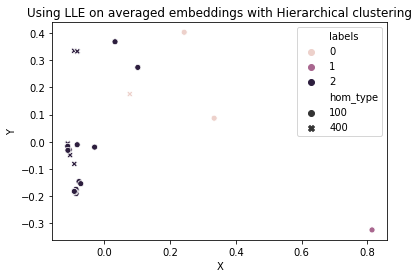

In [0]:
# For the word 'light'. Do not run this cell becuase the word under consideration might be different now. The plor will change depending on the word.
plt.title('Using LLE on averaged embeddings with Hierarchical clustering')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

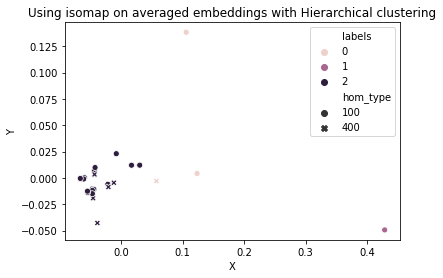

In [0]:
# For the word 'light'.
plt.title('Using isomap on averaged embeddings with Hierarchical clustering')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

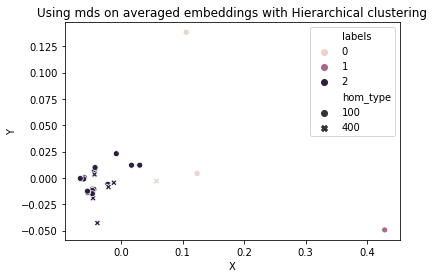

In [0]:
# For the word 'light'.
plt.title('Using mds on averaged embeddings with Hierarchical clustering')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

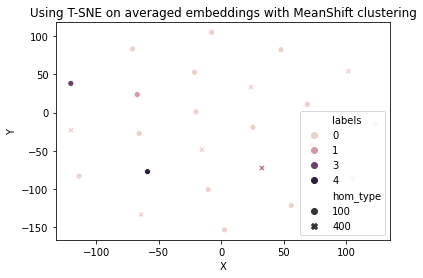

In [0]:
# For the word 'light'.
plt.title('Using T-SNE on averaged embeddings with MeanShift clustering')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

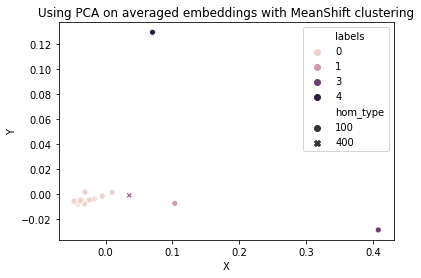

In [0]:
# For the word 'light'.
plt.title('Using PCA on averaged embeddings with MeanShift clustering')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

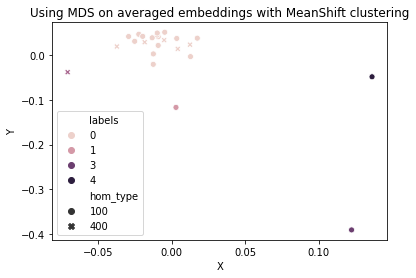

In [0]:
# For the word 'light'.
plt.title('Using MDS on averaged embeddings with MeanShift clustering')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

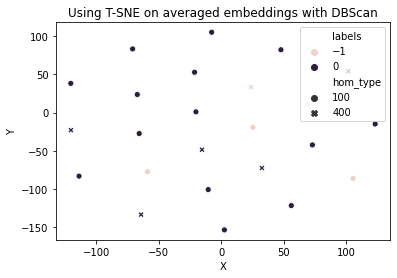

In [0]:
# For the word 'light'.
plt.title('Using T-SNE on averaged embeddings with DBScan')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

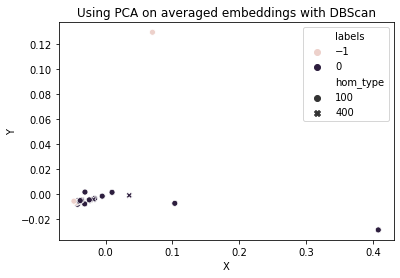

In [0]:
# For the word 'light'.
plt.title('Using PCA on averaged embeddings with DBScan')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

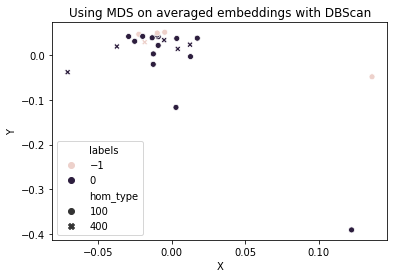

In [0]:
# For the word 'light'.
plt.title('Using MDS on averaged embeddings with DBScan')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

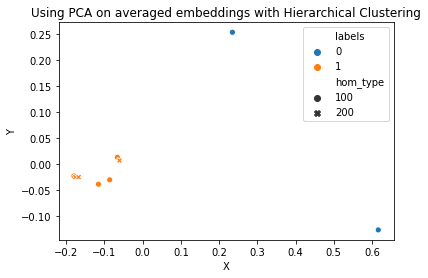

In [0]:
# For the word 'mean'.
plt.title('Using PCA on averaged embeddings with Hierarchical Clustering')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

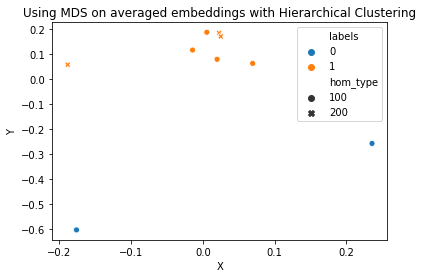

In [0]:
# For the word 'mean'.
plt.title('Using MDS on averaged embeddings with Hierarchical Clustering')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

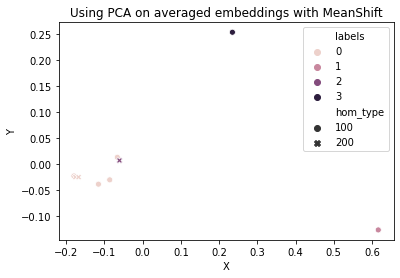

In [0]:
# For the word 'mean'.
plt.title('Using PCA on averaged embeddings with MeanShift')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

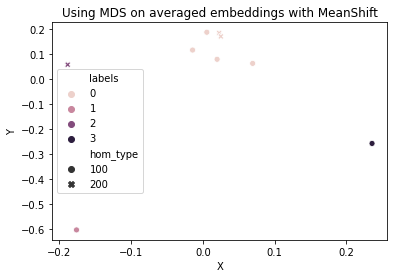

In [0]:
# For the word 'mean'.
plt.title('Using MDS on averaged embeddings with MeanShift')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

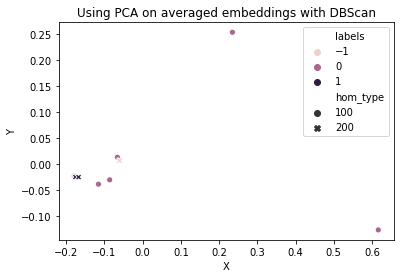

In [0]:
# For the word 'mean'.
plt.title('Using PCA on averaged embeddings with DBScan')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line

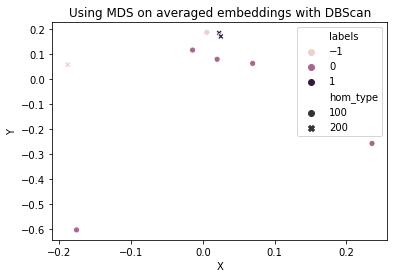

In [0]:
# For the word 'mean'.
plt.title('Using MDS on averaged embeddings with DBScan')
sns.scatterplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=relevant, # Data source
            hue='labels', style='hom_type')
           #fit_reg=False) # Don't fix a regression line